In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from queue import deque
import json
import os

In [2]:
def export_graph(theGraph, distances, path_dir):
    data_graph = nx.json_graph.node_link_data(theGraph)
    data_distances = distances.tolist()
    data = {
        'distances': data_distances,
        'graph': data_graph
    }

    with open(path_dir, 'w+') as outfile:  
        json.dump(data, outfile)

def import_graph(path_dir):
    with open(path_dir) as json_file:
        data = json.load(json_file)
        print(data['distances'])
        #print(data['graph'])
        graph = nx.json_graph.node_link_graph(data['graph'])
        return graph, data['distances']

In [3]:
def plot_graph(theGraph):
    nx.draw(theGraph)
    plt.subplot(121)
    nx.draw(theGraph, with_labels=True)
    plt.show()

In [4]:
def mount_graph():
    
    theGraph = nx.DiGraph()
    theGraph.add_node('pa1', id=1, local='A', time=1, team='pedreiro', build='A')
    theGraph.add_node('pb1', id=2, local='B', time=1, team='pedreiro', build='B')
    theGraph.add_node('pb2', id=3, local='B', time=1, team='pedreiro', build='B')

    theGraph.add_node('ea1', id=4, local='A', time=1, team='encanador', build='A')
    theGraph.add_node('ea2', id=5, local='A', time=1, team='encanador', build='A')
    theGraph.add_node('eb1', id=6, local='B', time=1, team='encanador', build='B')
    theGraph.add_node('eb2', id=7, local='B', time=1, team='encanador', build='B')
    theGraph.add_node('eb3', id=8, local='B', time=1, team='encanador', build='B')

    theGraph.add_node('la1', id=9, local='A', time=1, team='eletricista', build='A')
    theGraph.add_node('la2', id=10, local='A', time=1, team='eletricista', build='A')
    theGraph.add_node('lb1', id=11, local='B', time=1, team='eletricista', build='B')
    theGraph.add_node('lb2', id=12, local='B', time=1, team='eletricista', build='B')
    theGraph.add_node('lb3', id=13, local='B', time=1, team='eletricista', build='B')
    
    theGraph.add_edge('pa1','ea1')
    theGraph.add_edge('pa1','ea2')
    theGraph.add_edge('ea1','la1')
    theGraph.add_edge('ea2','la2')

    theGraph.add_edge('pb1','pb2')
    theGraph.add_edge('pb1','eb1')
    theGraph.add_edge('pb1','eb2')
    theGraph.add_edge('pb2','eb3')
    theGraph.add_edge('eb1','lb1')
    theGraph.add_edge('eb2','lb2')
    theGraph.add_edge('eb3','lb3')

    distances = np.zeros((2,2), dtype=int)
    distances[:] = 1

    return theGraph, distances

In [5]:
#train_csv = os.path.join(os.path.dirname(notebook_path), "Datasets/train.csv")
theGraph, distances = mount_graph()
export_graph(theGraph, distances, "/home/elvio/github/wsrp/graphs/exemplo5.txt")


[[1, 1], [1, 1]]


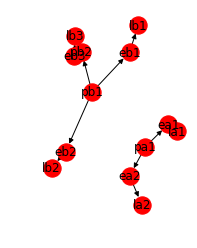

[[1, 1], [1, 1]]


In [6]:
def plot_graph(theGraph):
    nx.draw(theGraph)
    plt.subplot(121)
    nx.draw(theGraph, with_labels=True)    
    plt.show()

theGraph, distances = import_graph("/home/elvio/github/wsrp/graphs/exemplo5.txt")

plot_graph(theGraph)
print(distances)

In [7]:
def topological_sort(theGraph):
    
    topSort = []
    q = deque() 

    for edge in theGraph.in_degree:
        if edge[1] == 0:
            q.appendleft(edge[0])
    
    while q:
        node = q.pop()
        topSort.append(node)
        for adj in theGraph.adj[node]:
            if adj not in q:
                q.appendleft(adj)
    
    return topSort

order = topological_sort(theGraph)
print(order)

['pa1', 'pb1', 'ea1', 'ea2', 'pb2', 'eb1', 'eb2', 'la1', 'la2', 'eb3', 'lb1', 'lb2', 'lb3']


In [8]:
def show_schedule(schedules, order):
    print('ordenação topologica:')
    print(order, '\n')
    print('matriz de schedules:')
    
    for i in range(len(schedules)):
        print('dia:', i+1)
        for activity in schedules[i]:
            if 'deslocamento' in activity:
                print('\t', activity)
            else:
                print('\t', activity, theGraph.nodes[activity]['local'], theGraph.nodes[activity]['team'])

In [9]:
def define_work_period(theGraph, pos, teams):
    
    current_node = theGraph.nodes[pos]
    day = 0
    previous_day = 0
    for previous in theGraph.pred[pos]:
        if not theGraph.nodes[previous]['scheduled']:
            define_work_period(theGraph, previous)
        previous_day = theGraph.nodes[previous]['time'] + theGraph.nodes[previous]['day']
        if previous_day > day:
            day = previous_day
    team = teams[theGraph.nodes[pos]['team']]
    #print('team:', theGraph.nodes[pos]['team'], team)
    #print(team['schedules'], len(team['schedules']))
    
    #if len(team['schedules']) == 0:
        #team['schedules'].update( {day : theGraph.nodes[pos]['local']})
    previous_local = None
    
    if len(team['schedules']) > 0:
        last = sorted(team['schedules'].keys())[-1]
        #print('**********', last, team['schedules'][last])
        if day in team['schedules']:
            while day in team['schedules']:
                scheduled = team['schedules'][day]
                if 'deslocamento' not in scheduled:
                    previous_local = theGraph.nodes[team['schedules'][day]]['local']
                day += 1
        elif last in team['schedules']:
            previous_local = theGraph.nodes[team['schedules'][last]]['local']
            day = last + 1

        if previous_local != theGraph.nodes[pos]['local']:
            #print('deslocamento', theGraph.nodes[pos]['team'], previous_local, theGraph.nodes[pos]['local'])
            deslocamento = 'deslocamento: ' + theGraph.nodes[pos]['team'] +" "+ previous_local +" -> "+ theGraph.nodes[pos]['local']
            
            team['schedules'].update( {day : deslocamento})
            day += 1
    team['schedules'].update({day : pos})
    #print(day)
        
    #if team['local'] != theGraph.nodes[pos]['team']:
        #theGraph.nodes[pos]['local'] = team['local']
        #day += 1
    theGraph.nodes[pos]['day'] = day
    theGraph.nodes[pos]['scheduled'] = True 
    
    #print(theGraph.nodes[pos])
    #team['schedules'].update( {day : theGraph.nodes[pos]['team']})
    #print('----------------------')
    return day
    

def generate_wsrp_matrix(theGraph, order):
    n_nodes = len(theGraph)
    teams = {}
    for i in range(n_nodes):
        node = theGraph.nodes[order[i]] 
        teams.update({node['team']: {'quantity': 1, 'schedules':{}}})
        node['scheduled'] = False
        node['day'] = 0

    for team in teams:
        print(team, teams[team])
        
    #schedules = []
    #day = []
    #working = []
    day = 0
    for i in range(n_nodes):
        #print('--------------------')
        #print(theGraph.nodes[order[i]])
        day = define_work_period(theGraph, order[i], teams)
    
    return day, teams


theGraph, distances = import_graph("/home/elvio/github/wsrp/graphs/exemplo5.txt")
days, teams = generate_wsrp_matrix(theGraph, order)



[[1, 1], [1, 1]]
pedreiro {'quantity': 1, 'schedules': {}}
encanador {'quantity': 1, 'schedules': {}}
eletricista {'quantity': 1, 'schedules': {}}


In [10]:
def mount_schedules(theGraph, teams, days):
    schedules = []
    n_nodes = len(theGraph)

    for i in range(n_nodes):
        node = theGraph.nodes[order[i]]
        #print(order[i], node)
        day = []
    
        for team in teams:
            #print(teams[team]['schedules'])
            if i in teams[team]['schedules']:
                day.append(teams[team]['schedules'][i])
        if day:
            schedules.append(day)
    #print(schedules)
    return schedules

schedules = mount_schedules(theGraph, teams, days)
show_schedule(schedules, order)

ordenação topologica:
['pa1', 'pb1', 'ea1', 'ea2', 'pb2', 'eb1', 'eb2', 'la1', 'la2', 'eb3', 'lb1', 'lb2', 'lb3'] 

matriz de schedules:
dia: 1
	 pa1 A pedreiro
dia: 2
	 deslocamento: pedreiro A -> B
	 ea1 A encanador
dia: 3
	 pb1 B pedreiro
	 ea2 A encanador
	 la1 A eletricista
dia: 4
	 pb2 B pedreiro
	 deslocamento: encanador A -> B
	 la2 A eletricista
dia: 5
	 eb1 B encanador
	 deslocamento: eletricista A -> B
dia: 6
	 eb2 B encanador
	 lb1 B eletricista
dia: 7
	 eb3 B encanador
	 lb2 B eletricista
dia: 8
	 lb3 B eletricista
